In [1]:
#importing packages relevant to this project
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import cv2
%matplotlib inline

## Camera Calibration

### 1. Loading the images

In [2]:
def load_images(names_path, names_list):
    images = []
    for name in names_list:
        images.append(cv2.imread(names_path + name))
    return images

In [3]:
# Path Containing Calibration images
calibration_path = 'camera_cal/'

# Grid Dimensions
nx = 9
ny = 6

# Generate a standard 9x6 grid
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

calibration_image_names = os.listdir(calibration_path)


calibration_images = load_images(calibration_path, 
                                 calibration_image_names)
objpoints = []
imgpoints = []
for i in range(len(calibration_images)):
    image = calibration_images[i]
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(image, (nx,ny),None)

    # If corners were found, add an instance of the objectpoints representing a grid
    # Add Detected Corners to ImagePoints
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # draw corners and show
        img = cv2.drawChessboardCorners(image, (nx,ny), corners,ret)

In [4]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image.shape[::-1],None,None)

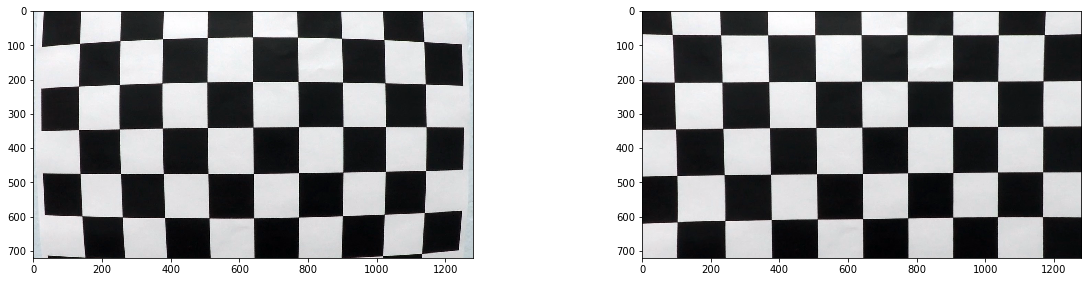

In [5]:
img = np.copy(calibration_images[0])
# undistort
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(img, cmap='gray')
plt.subplot(222)
plt.imshow(dst, cmap = 'gray')

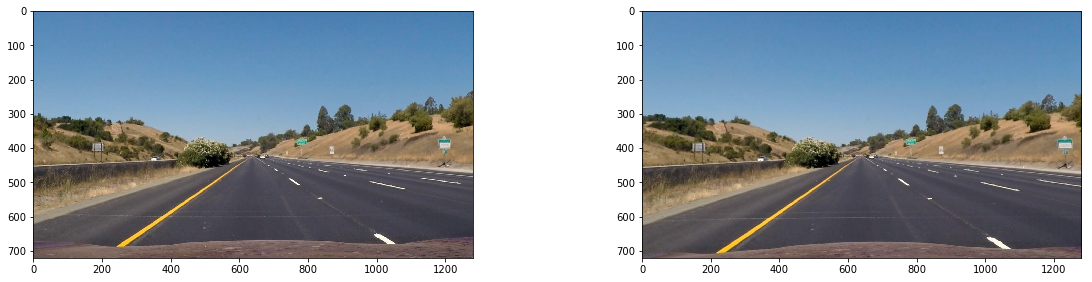

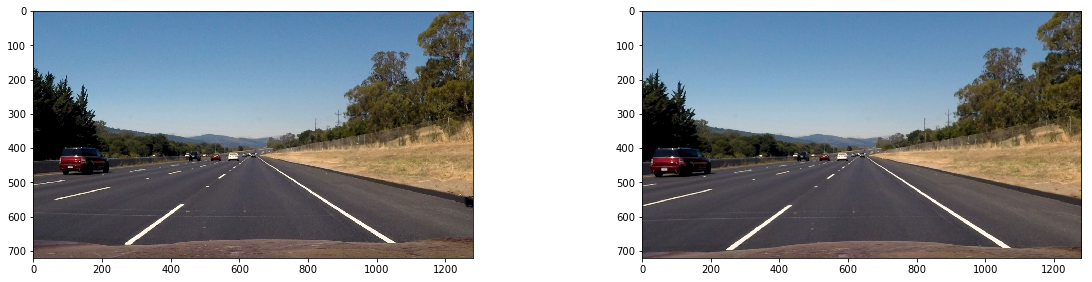

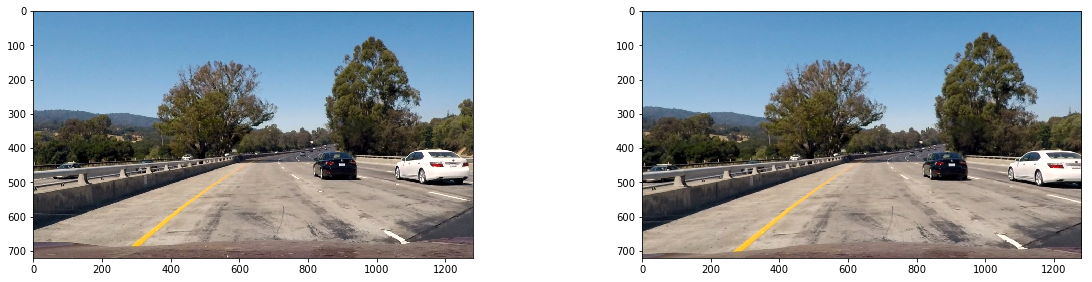

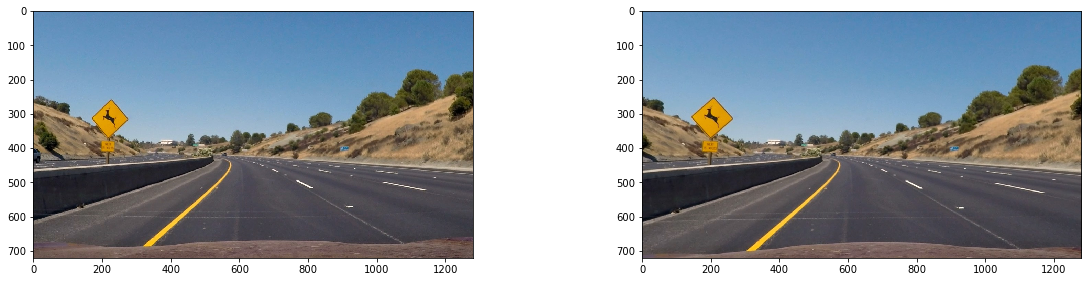

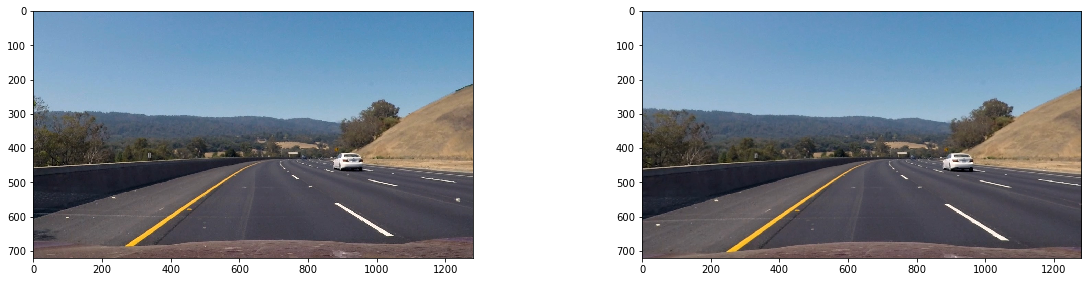

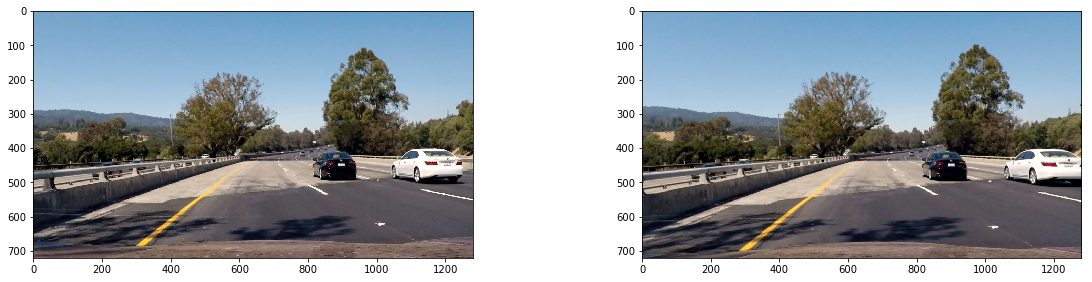

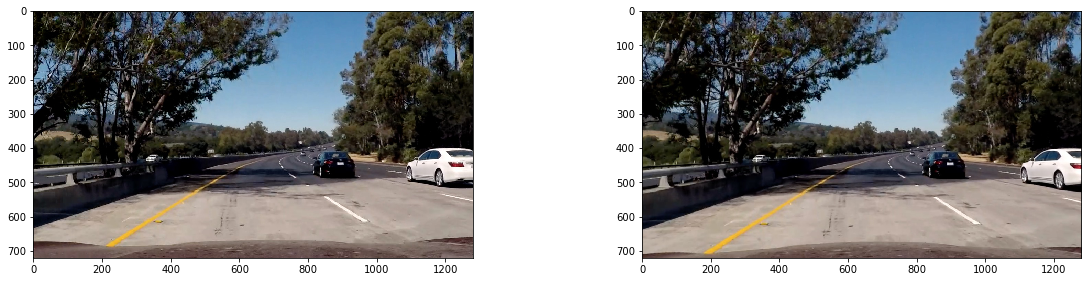

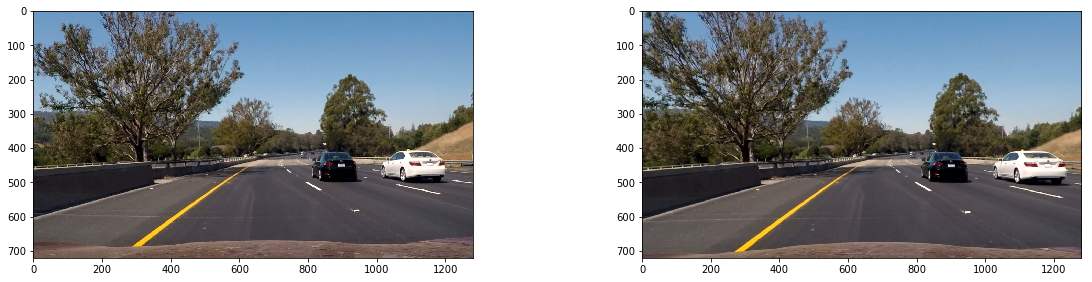

In [6]:
test_path = 'test_images/'
test_file_names = os.listdir(test_path)
test_images = load_images(test_path,test_file_names)
for i in range(len(test_images)):
    img = cv2.cvtColor(test_images[i],cv2.COLOR_BGR2RGB)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    plt.figure(i,figsize=(20,10))
    plt.subplot(221)
    plt.imshow(img, cmap='gray')
    plt.subplot(222)
    plt.imshow(dst, cmap = 'gray')
    test_images[i]=dst

In [13]:
img_size = test_images[0].shape
ht_window = np.uint(img_size[0]/1.5)
hb_window = np.uint(img_size[0])
c_window = np.uint(img_size[1]/2)
ctl_window = c_window - .2*np.uint(img_size[1]/2)
ctr_window = c_window + .2*np.uint(img_size[1]/2)
cbl_window = c_window - .9*np.uint(img_size[1]/2)
cbr_window = c_window + .9*np.uint(img_size[1]/2)

src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],[ctr_window,ht_window],[ctl_window,ht_window]])

dst = np.float32([[0,img_size[0]+30],[img_size[1],img_size[0]+30],
                  [img_size[1],0],[0,0]])

M = cv2.getPerspectiveTransform(src, dst)

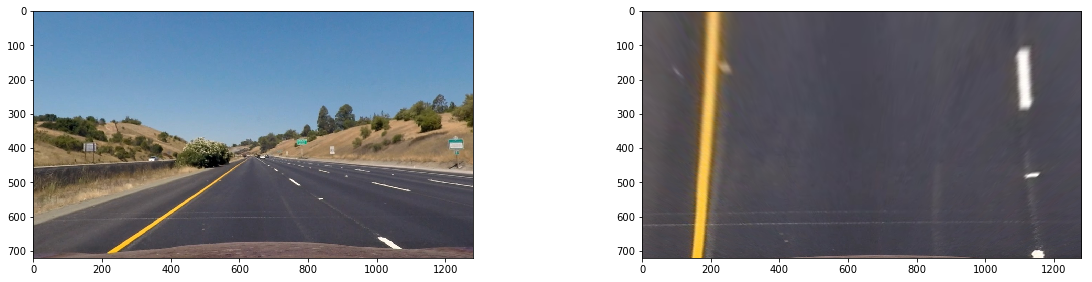

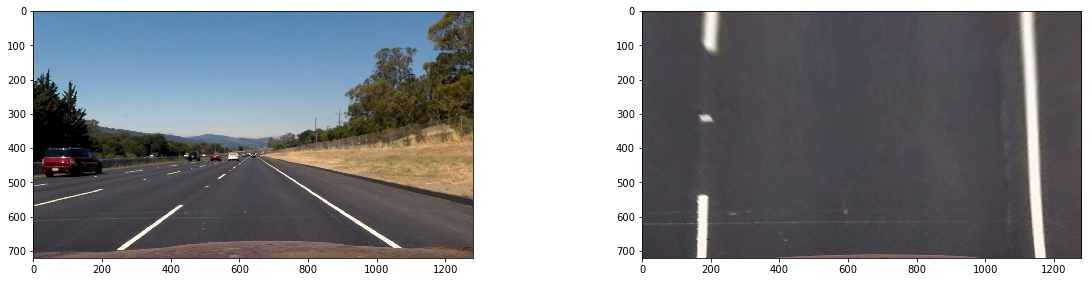

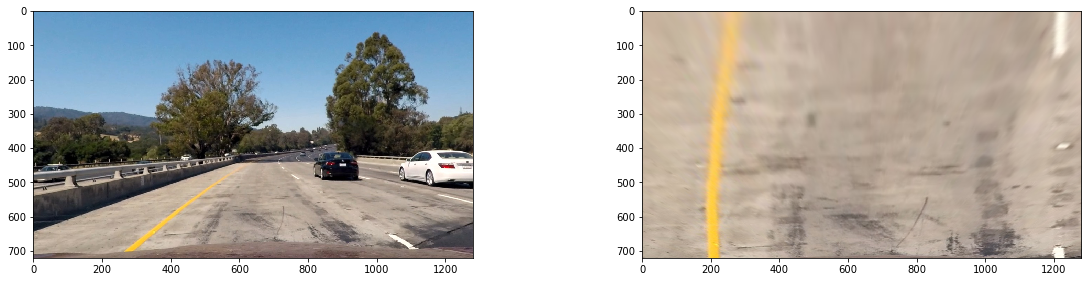

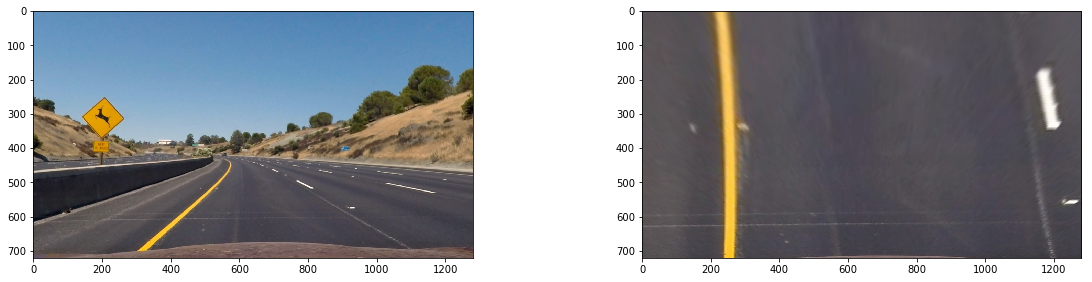

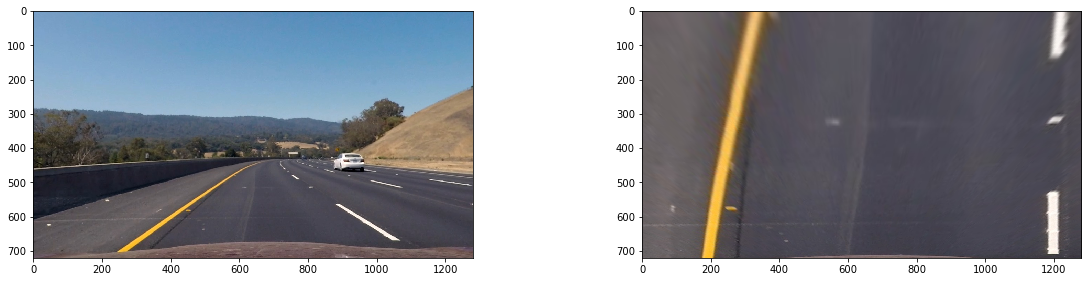

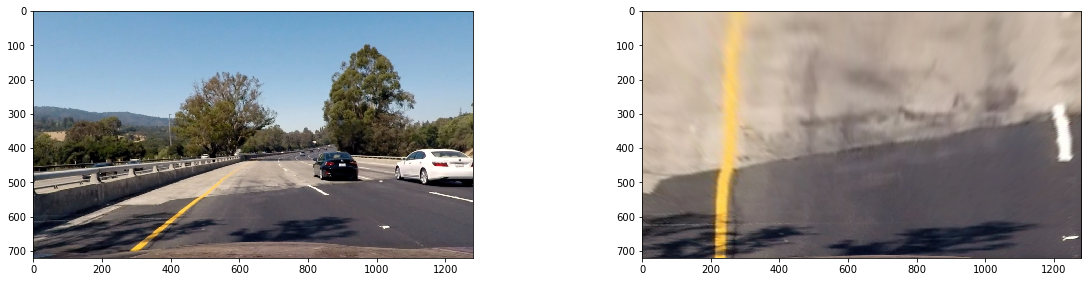

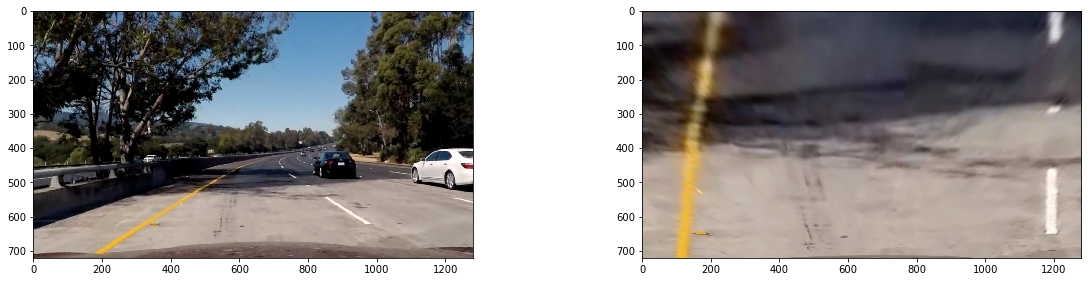

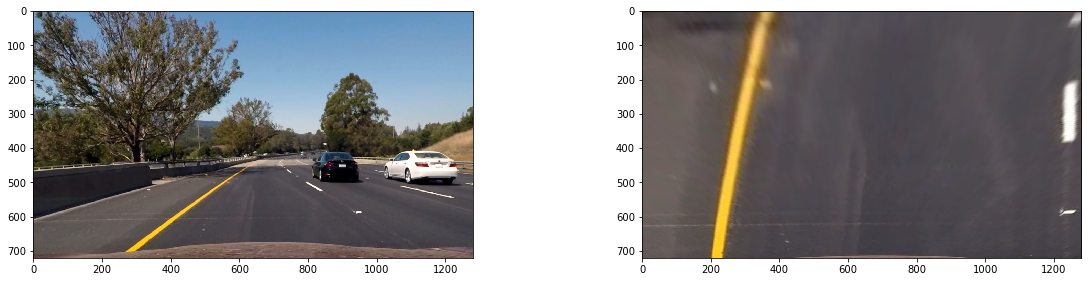

In [14]:
# Manually determined source and destination points
# src = np.float32([ [285,675], [1025,675], [670,440], [613,440] ])
# dst = np.float32([ [285,720], [1025,720], [1025,0], [285,0]])
# M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst,src)

ipm_images = []
for i in range(len(test_images)):
    img = test_images[i]
    
    warped = cv2.warpPerspective(img, M, 
                                        (img.shape[1],img.shape[0]),
                                        flags=cv2.INTER_LINEAR)
    blurred = cv2.GaussianBlur(warped,(5,5),0)
    cv2.addWeighted(warped, 1.5, blurred, -0.5, 0, warped);
    plt.figure(figsize=(20,10))
    plt.subplot(221)
    plt.imshow(img,cmap = 'gray')
    plt.subplot(222)
    plt.imshow(warped,cmap='gray')
    ipm_images.append(warped)

In [15]:
def get_sobel_by_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     gray = clahe.apply(gray)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient is 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    return binary_output

In [16]:
def get_gradient_magnitude_mask(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,  ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,  ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255. 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

In [ ]:
for image in test_images:
    mag_mask = get_gradient_magnitude_mask(image, sobel_kernel=9, mag_thresh = (40,100) )
    plt.imshow(mag_mask, cmap='gray')
    plt.show()

In [17]:
def get_gradient_direction_mask(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [ ]:
for image in test_images:
    dir_mask = get_gradient_direction_mask(image, sobel_kernel=15, thresh=(0.7,1.3))
    plt.imshow(dir_mask,cmap='gray')
    plt.show()

In [ ]:
ksize = 3
for image in test_images:
    gradx = get_sobel_by_thresh(image, orient='x', sobel_kernel=ksize, thresh=(0, 255))
    grady = get_sobel_by_thresh(image, orient='y', sobel_kernel=ksize, thresh=(0, 255))
    mag_binary = get_gradient_magnitude_mask(image, sobel_kernel=9, mag_thresh=(40, 100))
    dir_binary = get_gradient_direction_mask(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    combined = np.zeros_like(dir_binary)
    combined[((mag_binary == 1) & (dir_binary == 1))] = 1
    plt.imshow(combined,cmap='gray')
    plt.show()

In [18]:
def GaussianC_Adaptive_Threshold(img,kernel,cut_val):
    # Apply Gaussian adaptive thresholding
    img_cut = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,kernel,cut_val)
    return img_cut

def color_pipeline(img):    
    image_HSV = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    yellow_lb= np.array([ 0,  100,  100])
    yellow_ub = np.array([ 50, 255, 255])
    y_mask = cv2.inRange(image_HSV, yellow_lb, yellow_ub)
    yellow_bin = cv2.bitwise_and(img,img, mask= y_mask)
    
    white_lb  = np.array([ 0,   0,   160])
    white_ub = np.array([ 255,  10, 255])
    w_mask = cv2.inRange(image_HSV, white_lb, white_ub)
    white_bin = cv2.bitwise_and(img,img,mask=w_mask)    
    color_mask = cv2.bitwise_or(y_mask,w_mask)
    
    
    return color_mask

In [19]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    if orient=='x':
        img_s = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255*img_abs/np.max(img_abs))
    
    binary_output = 0*img_sobel
    binary_output[(img_sobel >= thresh[0]) & (img_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    img_sx = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    img_sy = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    
    img_s = np.sqrt(img_sx**2 + img_sy**2)
    img_s = np.uint8(img_s*255/np.max(img_s))
    binary_output = 0*img_s
    binary_output[(img_s>=thresh[0]) & (img_s<=thresh[1]) ]=1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    img_sx = cv2.Sobel(img,cv2.CV_64F,1,0, ksize=sobel_kernel)
    img_sy = cv2.Sobel(img,cv2.CV_64F,0,1, ksize=sobel_kernel)
    
    grad_s = np.arctan2(np.absolute(img_sy), np.absolute(img_sx))
    
    binary_output = 0*grad_s # Remove this line
    binary_output[(grad_s>=thresh[0]) & (grad_s<=thresh[1])] = 1
    return binary_output

def sobel_combined(image):
    # Apply combined sobel filter
    img_g_mag = mag_thresh(image,3,(20,150))
    img_d_mag = dir_threshold(image,3,(.6,1.1))
    img_abs_x = abs_sobel_thresh(image,'x',5,(50,200))
    img_abs_y = abs_sobel_thresh(image,'y',5,(50,200))
    sobel_combined = np.zeros_like(img_d_mag)
    sobel_combined[((img_abs_x == 1) & (img_abs_y == 1)) | \
               ((img_g_mag == 1) & (img_d_mag == 1))] = 1
    return sobel_combined

def gradient_pipeline(img):
    image_HLS = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    
    img_gs = image_HLS[:,:,1]
    #img_gs = cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
    sobel_c = sobel_combined(img_gs)
    #img_d_mag = dir_threshold(img_gs,3,(.6,1.1))
    #img_m_mag = mag_thresh(img_gs,5,(20,265))
    img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,225))
    img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,225))
    l_channel_sobel = np.copy(cv2.bitwise_or(img_abs_x, img_abs_y))
    
    img_gs = image_HLS[:,:,2]
    #img_gs = cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
    sobel_c = sobel_combined(img_gs)
    #img_d_mag = dir_threshold(img_gs,3,(.6,1.1))
    #img_m_mag = mag_thresh(img_gs,5,(20,265))
    img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,255))
    img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,255))

    s_channel_sobel = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    combined = cv2.bitwise_or(l_channel_sobel,s_channel_sobel)
    return combined
    

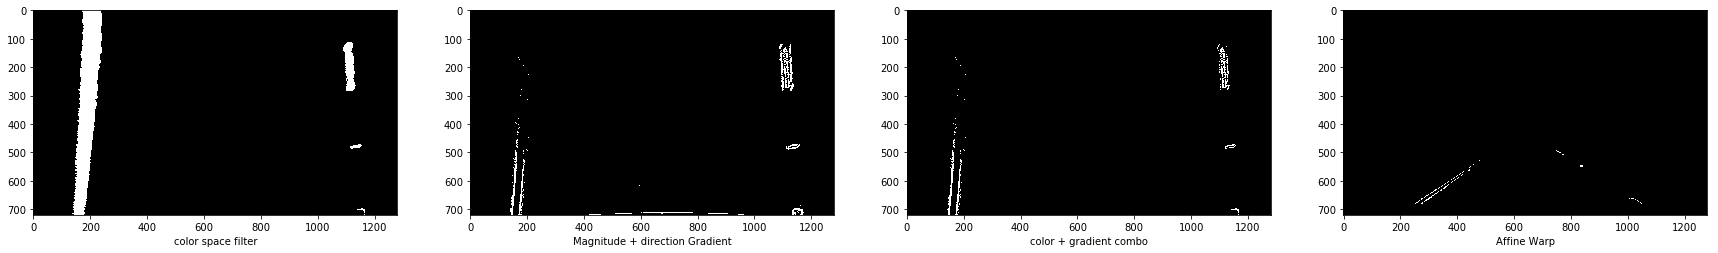

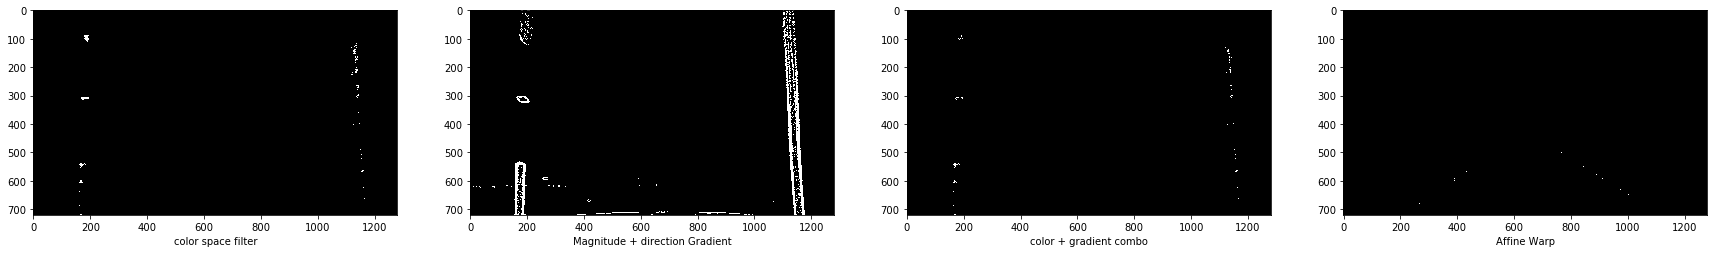

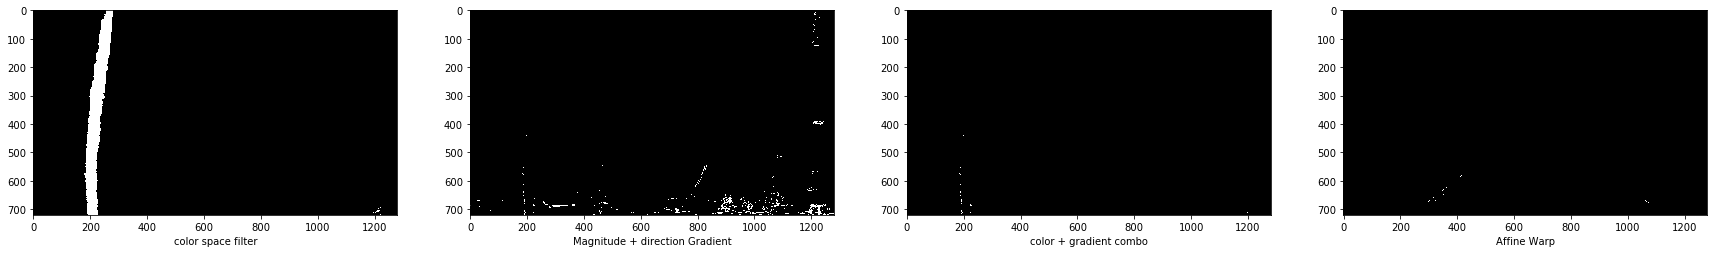

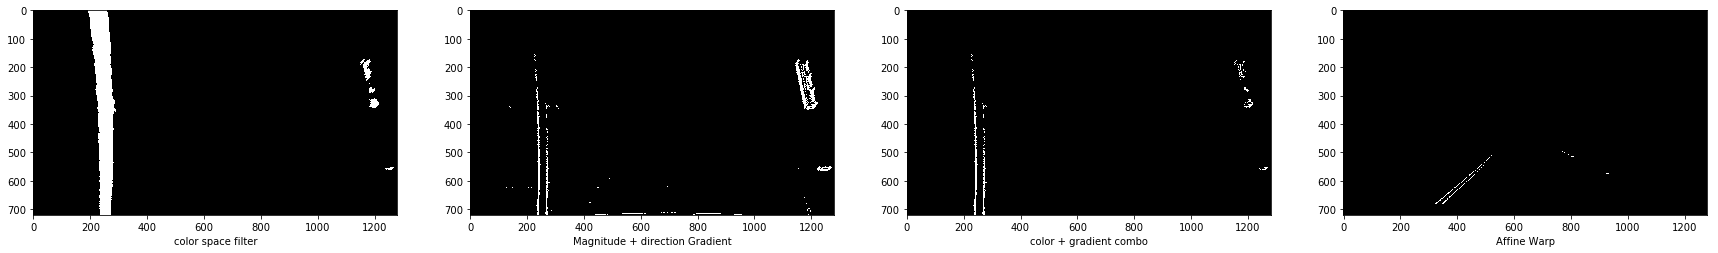

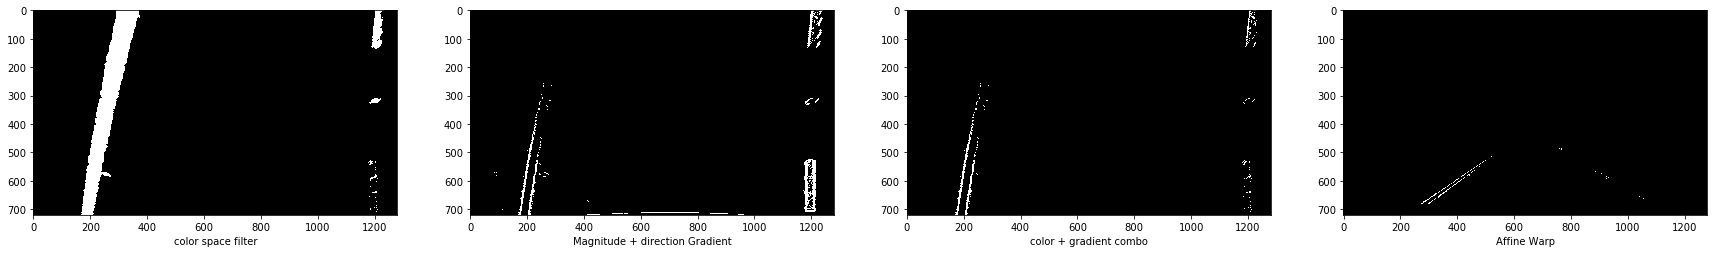

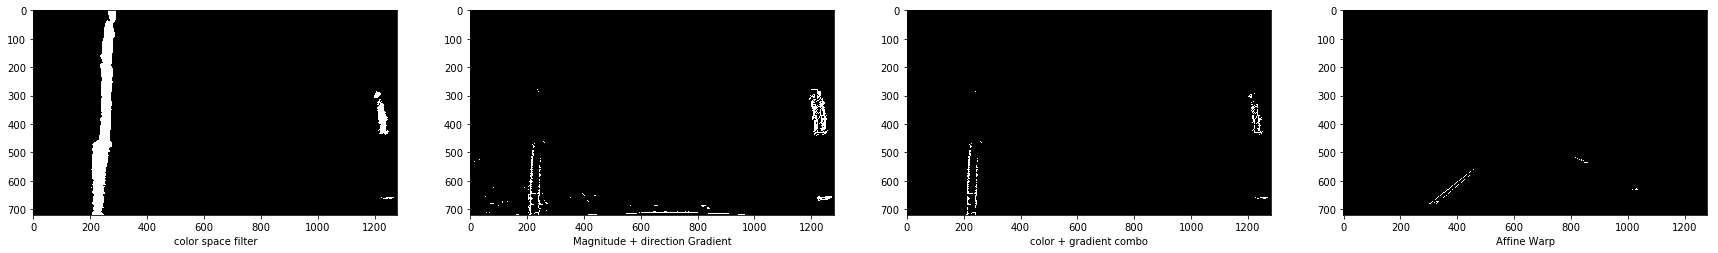

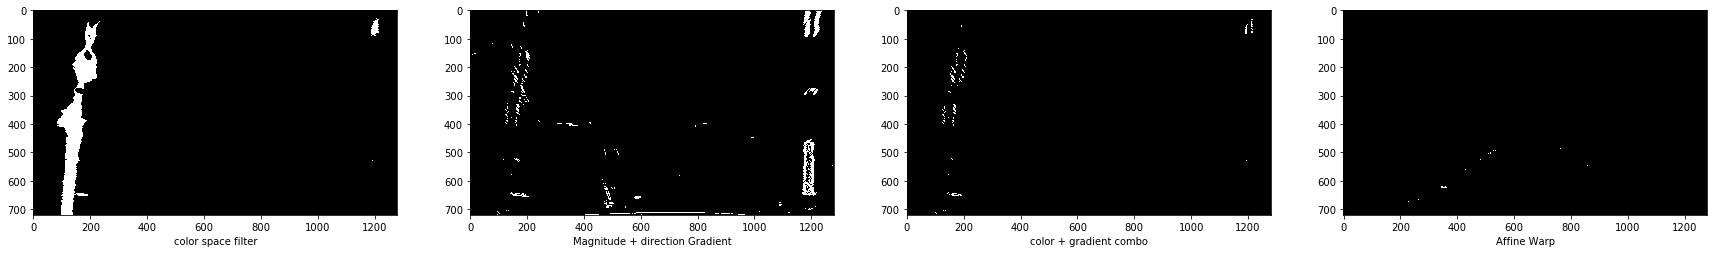

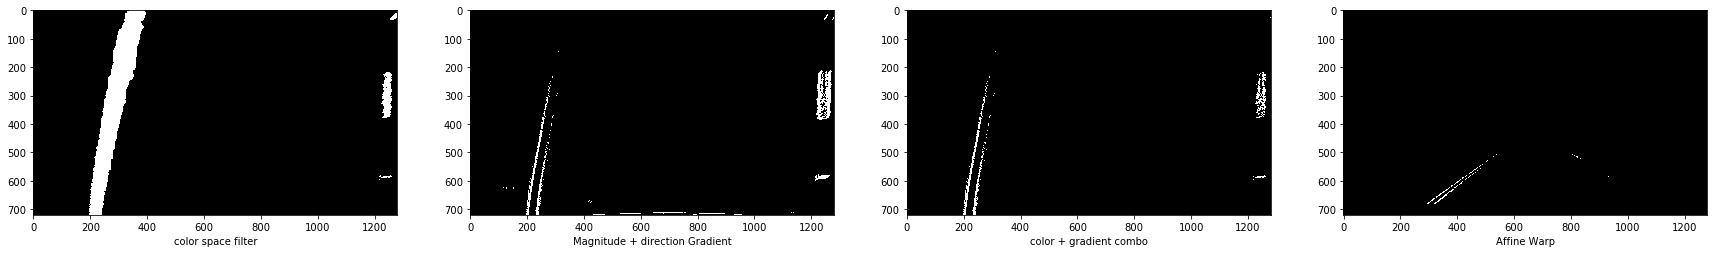

In [48]:
lane_masks = []
for image in ipm_images:
    color_mask = color_pipeline(image)

    grad_mask = gradient_pipeline(image)

    plt.figure(figsize=(30,15))
    plt.subplot(141)
    plt.xlabel('color space filter')
    plt.imshow(color_mask,cmap='gray')
    plt.subplot(142)
    plt.xlabel('Magnitude + direction Gradient')
    plt.imshow(grad_mask,cmap='gray')
    plt.subplot(143)
    
    lane_mask  = np.zeros_like(color_mask)
    lane_mask [ ( color_mask >=0.5 ) & (grad_mask >=0.5)] = 1
    plt.xlabel('color + gradient combo')
    plt.imshow(lane_mask,cmap = 'gray')
    plt.subplot(144)
    plt.xlabel('Affine Warp')
    lane_mask_in_perspective = cv2.warpPerspective(lane_mask, Minv, (image.shape[1], image.shape[0]))
    plt.imshow(lane_mask_in_perspective,cmap = 'gray')
    lane_masks.append(lane_mask)
    
    plt.show()

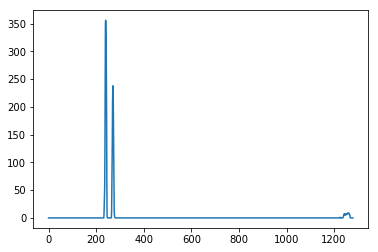

In [49]:
img = lane_masks[3]
histogram = np.sum(img[np.int32(img.shape[0]/2):,:], axis=0)
plt.plot(histogram)

In [ ]:
print (left_fit)
print (right_fit)

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(cv2.warpPerspective(image, Minv, (image.shape[1], image.shape[0])),cmap='gray')
plt.subplot(122)
plt.imshow(cv2.warpPerspective(result, Minv, (image.shape[1], image.shape[0])),cmap = 'gray')

In [ ]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

In [ ]:
ploty = np.linspace(0, len(leftx) - 1, num=len(leftx))# to cover same y-range as image

ym_per_pix = 30/300 # meters per pixel in y dimension
xm_per_pix = 3.7/350# meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
ploty = np.linspace(0, len(rightx) - 1, num=len(rightx))# to cover same y-range as image
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

In [50]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [116]:
def lane_finder(binary_warped):

    histogram = np.sum(binary_warped[np.int32(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    window_img = np.zeros_like(out_img)
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = np.zeros_like(window_img)
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
   
    
    return result, left_fit, right_fit

In [113]:
def annotate_frame(image):
    image =cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image_warped = cv2.warpPerspective(image, M, 
                                        (img.shape[1],img.shape[0]),
                                        flags=cv2.INTER_LINEAR)
    gradient_mask = gradient_pipeline(image_warped)
    color_mask = color_pipeline(image_warped)
    lane_mask  = np.zeros_like(color_mask)
    lane_mask [ ( color_mask >=0.5 ) | (gradient_mask >=0.5)] = 1
    
    disp_image,left_fit, right_fit = lane_finder(lane_mask)
    
    
    disp_image = cv2.warpPerspective(disp_image, Minv, 
                                        (image.shape[1],image.shape[0]),
                                        flags=cv2.INTER_LINEAR)
    
    result = cv2.addWeighted(image,1.0, disp_image,0.5,0)

    cv2.imshow('win', result)
    cv2.waitKey(1)
    return cv2.cvtColor(result,cv2.COLOR_RGB2BGR)

In [114]:
lane_output = 'annotated.mp4'
clip1 = VideoFileClip("./project_video.mp4")
annotated_clip = clip1.fl_image(annotate_frame)
%time annotated_clip.write_videofile(lane_output, audio=False)

720 720
[MoviePy] >>>> Building video annotated.mp4
[MoviePy] Writing video annotated.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<06:38,  3.16it/s]

720 720




  0%|          | 2/1261 [00:00<06:36,  3.18it/s]

720 720




  0%|          | 3/1261 [00:00<06:34,  3.19it/s]

720 720




  0%|          | 4/1261 [00:01<06:32,  3.20it/s]

720 720




  0%|          | 5/1261 [00:01<06:31,  3.21it/s]

720 720




  0%|          | 6/1261 [00:01<06:31,  3.20it/s]

720 720




  1%|          | 7/1261 [00:02<06:30,  3.21it/s]

720 720




  1%|          | 8/1261 [00:02<06:27,  3.23it/s]

720 720




  1%|          | 9/1261 [00:02<06:26,  3.24it/s]

720 720




  1%|          | 10/1261 [00:03<06:27,  3.23it/s]

720 720




  1%|          | 11/1261 [00:03<06:27,  3.22it/s]

720 720




  1%|          | 12/1261 [00:03<06:27,  3.22it/s]

720 720




  1%|          | 13/1261 [00:04<06:28,  3.21it/s]

720 720




  1%|          | 14/1261 [00:04<06:27,  3.22it/s]

720 720




  1%|          | 15/1261 [00:04<06:27,  3.22it/s]

720 720




  1%|▏         | 16/1261 [00:04<06:27,  3.22it/s]

720 720




  1%|▏         | 17/1261 [00:05<06:28,  3.20it/s]

720 720




  1%|▏         | 18/1261 [00:05<06:29,  3.19it/s]

720 720




  2%|▏         | 19/1261 [00:05<06:28,  3.20it/s]

720 720




  2%|▏         | 20/1261 [00:06<06:25,  3.22it/s]

720 720




  2%|▏         | 21/1261 [00:06<06:22,  3.24it/s]

720 720




  2%|▏         | 22/1261 [00:06<06:21,  3.25it/s]

720 720




  2%|▏         | 23/1261 [00:07<06:20,  3.25it/s]

720 720




  2%|▏         | 24/1261 [00:07<06:20,  3.25it/s]

720 720




  2%|▏         | 25/1261 [00:07<06:18,  3.26it/s]

720 720




  2%|▏         | 26/1261 [00:08<06:18,  3.27it/s]

720 720




  2%|▏         | 27/1261 [00:08<06:18,  3.26it/s]

720 720




  2%|▏         | 28/1261 [00:08<06:17,  3.27it/s]

720 720




  2%|▏         | 29/1261 [00:08<06:16,  3.27it/s]

720 720




  2%|▏         | 30/1261 [00:09<06:16,  3.27it/s]

720 720




  2%|▏         | 31/1261 [00:09<06:17,  3.26it/s]

720 720




  3%|▎         | 32/1261 [00:09<06:15,  3.27it/s]

720 720




  3%|▎         | 33/1261 [00:10<06:13,  3.29it/s]

720 720




  3%|▎         | 34/1261 [00:10<06:13,  3.28it/s]

720 720




  3%|▎         | 35/1261 [00:10<06:13,  3.28it/s]

720 720




  3%|▎         | 36/1261 [00:11<06:13,  3.28it/s]

720 720




  3%|▎         | 37/1261 [00:11<06:11,  3.30it/s]

720 720




  3%|▎         | 38/1261 [00:11<06:10,  3.30it/s]

720 720




  3%|▎         | 39/1261 [00:12<06:09,  3.31it/s]

720 720




  3%|▎         | 40/1261 [00:12<06:09,  3.31it/s]

720 720




  3%|▎         | 41/1261 [00:12<06:11,  3.28it/s]

720 720




  3%|▎         | 42/1261 [00:12<06:11,  3.28it/s]

720 720




  3%|▎         | 43/1261 [00:13<06:11,  3.28it/s]

720 720




  3%|▎         | 44/1261 [00:13<06:12,  3.27it/s]

720 720




  4%|▎         | 45/1261 [00:13<06:11,  3.28it/s]

720 720




  4%|▎         | 46/1261 [00:14<06:09,  3.29it/s]

720 720




  4%|▎         | 47/1261 [00:14<06:07,  3.30it/s]

720 720




  4%|▍         | 48/1261 [00:14<06:07,  3.30it/s]

720 720




  4%|▍         | 49/1261 [00:15<06:06,  3.30it/s]

720 720




  4%|▍         | 50/1261 [00:15<06:05,  3.31it/s]

720 720




  4%|▍         | 51/1261 [00:15<06:08,  3.28it/s]

720 720




  4%|▍         | 52/1261 [00:15<06:08,  3.28it/s]

720 720




  4%|▍         | 53/1261 [00:16<06:06,  3.29it/s]

720 720




  4%|▍         | 54/1261 [00:16<06:07,  3.28it/s]

720 720




  4%|▍         | 55/1261 [00:16<06:10,  3.25it/s]

720 720




  4%|▍         | 56/1261 [00:17<06:10,  3.25it/s]

720 720




  5%|▍         | 57/1261 [00:17<06:10,  3.25it/s]

720 720




  5%|▍         | 58/1261 [00:17<06:09,  3.25it/s]

720 720




  5%|▍         | 59/1261 [00:18<06:09,  3.25it/s]

720 720




  5%|▍         | 60/1261 [00:18<06:08,  3.26it/s]

720 720




  5%|▍         | 61/1261 [00:18<06:07,  3.26it/s]

720 720




  5%|▍         | 62/1261 [00:19<06:06,  3.27it/s]

720 720




  5%|▍         | 63/1261 [00:19<06:08,  3.25it/s]

720 720




  5%|▌         | 64/1261 [00:19<06:07,  3.26it/s]

720 720




  5%|▌         | 65/1261 [00:19<06:06,  3.26it/s]

720 720




  5%|▌         | 66/1261 [00:20<06:06,  3.26it/s]

720 720




  5%|▌         | 67/1261 [00:20<06:06,  3.26it/s]

720 720




  5%|▌         | 68/1261 [00:20<06:06,  3.26it/s]

720 720




  5%|▌         | 69/1261 [00:21<06:04,  3.27it/s]

720 720




  6%|▌         | 70/1261 [00:21<06:05,  3.26it/s]

720 720




  6%|▌         | 71/1261 [00:21<06:02,  3.28it/s]

720 720




  6%|▌         | 72/1261 [00:22<06:04,  3.26it/s]

720 720




  6%|▌         | 73/1261 [00:22<06:06,  3.24it/s]

720 720




  6%|▌         | 74/1261 [00:22<06:05,  3.24it/s]

720 720




  6%|▌         | 75/1261 [00:23<06:06,  3.24it/s]

720 720




  6%|▌         | 76/1261 [00:23<06:05,  3.24it/s]

720 720




  6%|▌         | 77/1261 [00:23<06:04,  3.24it/s]

720 720




  6%|▌         | 78/1261 [00:23<06:05,  3.24it/s]

720 720




  6%|▋         | 79/1261 [00:24<06:04,  3.25it/s]

720 720




  6%|▋         | 80/1261 [00:24<06:03,  3.25it/s]

720 720




  6%|▋         | 81/1261 [00:24<06:03,  3.25it/s]

720 720




  7%|▋         | 82/1261 [00:25<06:03,  3.24it/s]

720 720




  7%|▋         | 83/1261 [00:25<06:01,  3.26it/s]

720 720




  7%|▋         | 84/1261 [00:25<06:00,  3.26it/s]

720 720




  7%|▋         | 85/1261 [00:26<05:59,  3.27it/s]

720 720




  7%|▋         | 86/1261 [00:26<05:58,  3.27it/s]

720 720




  7%|▋         | 87/1261 [00:26<05:58,  3.27it/s]

720 720




  7%|▋         | 88/1261 [00:27<06:00,  3.25it/s]

720 720




  7%|▋         | 89/1261 [00:27<06:00,  3.25it/s]

720 720




  7%|▋         | 90/1261 [00:27<05:59,  3.25it/s]

720 720




  7%|▋         | 91/1261 [00:27<05:58,  3.26it/s]

720 720




  7%|▋         | 92/1261 [00:28<05:58,  3.26it/s]

720 720




  7%|▋         | 93/1261 [00:28<06:01,  3.23it/s]

720 720




  7%|▋         | 94/1261 [00:28<05:59,  3.25it/s]

720 720




  8%|▊         | 95/1261 [00:29<05:54,  3.29it/s]

720 720




  8%|▊         | 96/1261 [00:29<05:56,  3.27it/s]

720 720




  8%|▊         | 97/1261 [00:29<05:55,  3.27it/s]

720 720




  8%|▊         | 98/1261 [00:30<05:58,  3.25it/s]

720 720




  8%|▊         | 99/1261 [00:30<05:56,  3.26it/s]

720 720




  8%|▊         | 100/1261 [00:30<05:58,  3.24it/s]

720 720




  8%|▊         | 101/1261 [00:31<05:58,  3.23it/s]

720 720




  8%|▊         | 102/1261 [00:31<05:57,  3.24it/s]

720 720




  8%|▊         | 103/1261 [00:31<05:57,  3.24it/s]

720 720




  8%|▊         | 104/1261 [00:31<05:57,  3.24it/s]

720 720




  8%|▊         | 105/1261 [00:32<05:55,  3.25it/s]

720 720




  8%|▊         | 106/1261 [00:32<05:52,  3.27it/s]

720 720




  8%|▊         | 107/1261 [00:32<05:50,  3.29it/s]

720 720




  9%|▊         | 108/1261 [00:33<05:47,  3.32it/s]

720 720




  9%|▊         | 109/1261 [00:33<05:49,  3.30it/s]

720 720




  9%|▊         | 110/1261 [00:33<05:50,  3.28it/s]

720 720




  9%|▉         | 111/1261 [00:34<05:50,  3.28it/s]

720 720




  9%|▉         | 112/1261 [00:34<05:51,  3.27it/s]

720 720




  9%|▉         | 113/1261 [00:34<05:49,  3.28it/s]

720 720




  9%|▉         | 114/1261 [00:34<05:51,  3.26it/s]

720 720




  9%|▉         | 115/1261 [00:35<05:51,  3.26it/s]

720 720




  9%|▉         | 116/1261 [00:35<05:51,  3.26it/s]

720 720




  9%|▉         | 117/1261 [00:35<05:51,  3.26it/s]

720 720




  9%|▉         | 118/1261 [00:36<05:51,  3.25it/s]

720 720




  9%|▉         | 119/1261 [00:36<05:52,  3.24it/s]

720 720




 10%|▉         | 120/1261 [00:36<05:52,  3.24it/s]

720 720




 10%|▉         | 121/1261 [00:37<05:52,  3.24it/s]

720 720




 10%|▉         | 122/1261 [00:37<05:53,  3.23it/s]

720 720




 10%|▉         | 123/1261 [00:37<05:49,  3.25it/s]

720 720




 10%|▉         | 124/1261 [00:38<05:48,  3.26it/s]

720 720




 10%|▉         | 125/1261 [00:38<05:49,  3.25it/s]

720 720




 10%|▉         | 126/1261 [00:38<05:50,  3.24it/s]

720 720




 10%|█         | 127/1261 [00:39<05:50,  3.24it/s]

720 720




 10%|█         | 128/1261 [00:39<05:47,  3.26it/s]

720 720




 10%|█         | 129/1261 [00:39<05:46,  3.27it/s]

720 720




 10%|█         | 130/1261 [00:39<05:46,  3.26it/s]

720 720




 10%|█         | 131/1261 [00:40<05:48,  3.24it/s]

720 720




 10%|█         | 132/1261 [00:40<05:47,  3.25it/s]

720 720




 11%|█         | 133/1261 [00:40<05:45,  3.26it/s]

720 720




 11%|█         | 134/1261 [00:41<05:47,  3.24it/s]

720 720




 11%|█         | 135/1261 [00:41<05:50,  3.21it/s]

720 720




 11%|█         | 136/1261 [00:41<05:54,  3.18it/s]

720 720




 11%|█         | 137/1261 [00:42<05:54,  3.17it/s]

720 720




 11%|█         | 138/1261 [00:42<05:52,  3.18it/s]

720 720




 11%|█         | 139/1261 [00:42<05:53,  3.18it/s]

720 720




 11%|█         | 140/1261 [00:43<05:49,  3.20it/s]

720 720




 11%|█         | 141/1261 [00:43<05:53,  3.17it/s]

720 720




 11%|█▏        | 142/1261 [00:43<05:55,  3.15it/s]

720 720




 11%|█▏        | 143/1261 [00:43<05:51,  3.18it/s]

720 720




 11%|█▏        | 144/1261 [00:44<05:48,  3.21it/s]

720 720




 11%|█▏        | 145/1261 [00:44<05:45,  3.23it/s]

720 720




 12%|█▏        | 146/1261 [00:44<05:42,  3.26it/s]

720 720




 12%|█▏        | 147/1261 [00:45<05:42,  3.26it/s]

720 720




 12%|█▏        | 148/1261 [00:45<05:44,  3.23it/s]

720 720




 12%|█▏        | 149/1261 [00:45<05:46,  3.21it/s]

720 720




 12%|█▏        | 150/1261 [00:46<05:42,  3.24it/s]

720 720




 12%|█▏        | 151/1261 [00:46<05:43,  3.23it/s]

720 720




 12%|█▏        | 152/1261 [00:46<05:40,  3.25it/s]

720 720




 12%|█▏        | 153/1261 [00:47<05:40,  3.25it/s]

720 720




 12%|█▏        | 154/1261 [00:47<05:40,  3.25it/s]

720 720




 12%|█▏        | 155/1261 [00:47<05:38,  3.27it/s]

720 720




 12%|█▏        | 156/1261 [00:47<05:35,  3.29it/s]

720 720




 12%|█▏        | 157/1261 [00:48<05:35,  3.29it/s]

720 720




 13%|█▎        | 158/1261 [00:48<05:34,  3.30it/s]

720 720




 13%|█▎        | 159/1261 [00:48<05:33,  3.31it/s]

720 720




 13%|█▎        | 160/1261 [00:49<05:33,  3.31it/s]

720 720




 13%|█▎        | 161/1261 [00:49<05:34,  3.28it/s]

720 720




 13%|█▎        | 162/1261 [00:49<05:34,  3.29it/s]

720 720




 13%|█▎        | 163/1261 [00:50<05:32,  3.30it/s]

720 720




 13%|█▎        | 164/1261 [00:50<05:34,  3.28it/s]

720 720




 13%|█▎        | 165/1261 [00:50<05:34,  3.28it/s]

720 720




 13%|█▎        | 166/1261 [00:51<05:34,  3.28it/s]

720 720




 13%|█▎        | 167/1261 [00:51<05:34,  3.27it/s]

720 720




 13%|█▎        | 168/1261 [00:51<05:36,  3.25it/s]

720 720




 13%|█▎        | 169/1261 [00:51<05:36,  3.25it/s]

720 720




 13%|█▎        | 170/1261 [00:52<05:34,  3.26it/s]

720 720




 14%|█▎        | 171/1261 [00:52<05:33,  3.27it/s]

720 720




 14%|█▎        | 172/1261 [00:52<05:31,  3.29it/s]

720 720




 14%|█▎        | 173/1261 [00:53<05:29,  3.30it/s]

720 720




 14%|█▍        | 174/1261 [00:53<05:31,  3.28it/s]

720 720




 14%|█▍        | 175/1261 [00:53<05:31,  3.28it/s]

720 720




 14%|█▍        | 176/1261 [00:54<05:29,  3.30it/s]

720 720




 14%|█▍        | 177/1261 [00:54<05:27,  3.31it/s]

720 720




 14%|█▍        | 178/1261 [00:54<05:27,  3.31it/s]

720 720




 14%|█▍        | 179/1261 [00:54<05:26,  3.31it/s]

720 720




 14%|█▍        | 180/1261 [00:55<05:27,  3.30it/s]

720 720




 14%|█▍        | 181/1261 [00:55<05:31,  3.26it/s]

720 720




 14%|█▍        | 182/1261 [00:55<05:30,  3.26it/s]

720 720




 15%|█▍        | 183/1261 [00:56<05:29,  3.27it/s]

720 720




 15%|█▍        | 184/1261 [00:56<05:28,  3.28it/s]

720 720




 15%|█▍        | 185/1261 [00:56<05:29,  3.27it/s]

720 720




 15%|█▍        | 186/1261 [00:57<05:29,  3.27it/s]

720 720




 15%|█▍        | 187/1261 [00:57<05:30,  3.25it/s]

720 720




 15%|█▍        | 188/1261 [00:57<05:28,  3.27it/s]

720 720




 15%|█▍        | 189/1261 [00:58<05:26,  3.28it/s]

720 720




 15%|█▌        | 190/1261 [00:58<05:25,  3.29it/s]

720 720




 15%|█▌        | 191/1261 [00:58<05:25,  3.28it/s]

720 720




 15%|█▌        | 192/1261 [00:58<05:26,  3.27it/s]

720 720




 15%|█▌        | 193/1261 [00:59<05:28,  3.25it/s]

720 720




 15%|█▌        | 194/1261 [00:59<05:26,  3.27it/s]

720 720




 15%|█▌        | 195/1261 [00:59<05:24,  3.29it/s]

720 720




 16%|█▌        | 196/1261 [01:00<05:23,  3.30it/s]

720 720




 16%|█▌        | 197/1261 [01:00<05:22,  3.30it/s]

720 720




 16%|█▌        | 198/1261 [01:00<05:22,  3.30it/s]

720 720




 16%|█▌        | 199/1261 [01:01<05:23,  3.28it/s]

720 720




 16%|█▌        | 200/1261 [01:01<05:23,  3.28it/s]

720 720




 16%|█▌        | 201/1261 [01:01<05:25,  3.25it/s]

720 720




 16%|█▌        | 202/1261 [01:02<05:26,  3.24it/s]

720 720




 16%|█▌        | 203/1261 [01:02<05:25,  3.25it/s]

720 720




 16%|█▌        | 204/1261 [01:02<05:23,  3.27it/s]

720 720




 16%|█▋        | 205/1261 [01:02<05:20,  3.29it/s]

720 720




 16%|█▋        | 206/1261 [01:03<05:20,  3.29it/s]

720 720




 16%|█▋        | 207/1261 [01:03<05:19,  3.30it/s]

720 720




 16%|█▋        | 208/1261 [01:03<05:18,  3.31it/s]

720 720




 17%|█▋        | 209/1261 [01:04<05:18,  3.31it/s]

720 720




 17%|█▋        | 210/1261 [01:04<05:17,  3.31it/s]

720 720




 17%|█▋        | 211/1261 [01:04<05:20,  3.28it/s]

720 720




 17%|█▋        | 212/1261 [01:05<05:20,  3.27it/s]

720 720




 17%|█▋        | 213/1261 [01:05<05:22,  3.25it/s]

720 720




 17%|█▋        | 214/1261 [01:05<05:23,  3.23it/s]

720 720




 17%|█▋        | 215/1261 [01:05<05:24,  3.22it/s]

720 720




 17%|█▋        | 216/1261 [01:06<05:24,  3.22it/s]

720 720




 17%|█▋        | 217/1261 [01:06<05:23,  3.22it/s]

720 720




 17%|█▋        | 218/1261 [01:06<05:24,  3.21it/s]

720 720




 17%|█▋        | 219/1261 [01:07<05:24,  3.21it/s]

720 720




 17%|█▋        | 220/1261 [01:07<05:22,  3.23it/s]

720 720




 18%|█▊        | 221/1261 [01:07<05:23,  3.22it/s]

720 720




 18%|█▊        | 222/1261 [01:08<05:21,  3.23it/s]

720 720




 18%|█▊        | 223/1261 [01:08<05:20,  3.24it/s]

720 720




 18%|█▊        | 224/1261 [01:08<05:17,  3.26it/s]

720 720




 18%|█▊        | 225/1261 [01:09<05:16,  3.27it/s]

720 720




 18%|█▊        | 226/1261 [01:09<05:17,  3.26it/s]

720 720




 18%|█▊        | 227/1261 [01:09<05:18,  3.24it/s]

720 720




 18%|█▊        | 228/1261 [01:09<05:18,  3.25it/s]

720 720




 18%|█▊        | 229/1261 [01:10<05:17,  3.25it/s]

720 720




 18%|█▊        | 230/1261 [01:10<05:17,  3.25it/s]

720 720




 18%|█▊        | 231/1261 [01:10<05:18,  3.24it/s]

720 720




 18%|█▊        | 232/1261 [01:11<05:17,  3.24it/s]

720 720




 18%|█▊        | 233/1261 [01:11<05:16,  3.25it/s]

720 720




 19%|█▊        | 234/1261 [01:11<05:14,  3.26it/s]

720 720




 19%|█▊        | 235/1261 [01:12<05:14,  3.26it/s]

720 720




 19%|█▊        | 236/1261 [01:12<05:12,  3.28it/s]

720 720




 19%|█▉        | 237/1261 [01:12<05:11,  3.29it/s]

720 720




 19%|█▉        | 238/1261 [01:13<05:12,  3.28it/s]

720 720




 19%|█▉        | 239/1261 [01:13<05:12,  3.27it/s]

720 720




 19%|█▉        | 240/1261 [01:13<05:12,  3.27it/s]

720 720




 19%|█▉        | 241/1261 [01:13<05:14,  3.25it/s]

720 720




 19%|█▉        | 242/1261 [01:14<05:13,  3.25it/s]

720 720




 19%|█▉        | 243/1261 [01:14<05:13,  3.25it/s]

720 720




 19%|█▉        | 244/1261 [01:14<05:11,  3.27it/s]

720 720




 19%|█▉        | 245/1261 [01:15<05:11,  3.26it/s]

720 720




 20%|█▉        | 246/1261 [01:15<05:11,  3.26it/s]

720 720




 20%|█▉        | 247/1261 [01:15<05:11,  3.26it/s]

720 720




 20%|█▉        | 248/1261 [01:16<05:11,  3.25it/s]

720 720




 20%|█▉        | 249/1261 [01:16<05:09,  3.27it/s]

720 720




 20%|█▉        | 250/1261 [01:16<05:08,  3.27it/s]

720 720




 20%|█▉        | 251/1261 [01:17<05:08,  3.28it/s]

720 720




 20%|█▉        | 252/1261 [01:17<05:09,  3.26it/s]

720 720




 20%|██        | 253/1261 [01:17<05:10,  3.24it/s]

720 720




 20%|██        | 254/1261 [01:17<05:08,  3.26it/s]

720 720




 20%|██        | 255/1261 [01:18<05:08,  3.26it/s]

720 720




 20%|██        | 256/1261 [01:18<05:08,  3.25it/s]

720 720




 20%|██        | 257/1261 [01:18<05:08,  3.26it/s]

720 720




 20%|██        | 258/1261 [01:19<05:08,  3.25it/s]

720 720




 21%|██        | 259/1261 [01:19<05:07,  3.25it/s]

720 720




 21%|██        | 260/1261 [01:19<05:04,  3.29it/s]

720 720




 21%|██        | 261/1261 [01:20<05:04,  3.29it/s]

720 720




 21%|██        | 262/1261 [01:20<05:03,  3.29it/s]

720 720




 21%|██        | 263/1261 [01:20<05:04,  3.28it/s]

720 720




 21%|██        | 264/1261 [01:21<05:05,  3.26it/s]

720 720




 21%|██        | 265/1261 [01:21<05:06,  3.25it/s]

720 720




 21%|██        | 266/1261 [01:21<05:07,  3.23it/s]

720 720




 21%|██        | 267/1261 [01:21<05:06,  3.24it/s]

720 720




 21%|██▏       | 268/1261 [01:22<05:07,  3.23it/s]

720 720




 21%|██▏       | 269/1261 [01:22<05:05,  3.24it/s]

720 720




 21%|██▏       | 270/1261 [01:22<05:06,  3.23it/s]

720 720




 21%|██▏       | 271/1261 [01:23<05:06,  3.23it/s]

720 720




 22%|██▏       | 272/1261 [01:23<05:06,  3.22it/s]

720 720




 22%|██▏       | 273/1261 [01:23<05:04,  3.25it/s]

720 720




 22%|██▏       | 274/1261 [01:24<05:04,  3.25it/s]

720 720




 22%|██▏       | 275/1261 [01:24<05:03,  3.25it/s]

720 720




 22%|██▏       | 276/1261 [01:24<05:03,  3.25it/s]

720 720




 22%|██▏       | 277/1261 [01:25<05:00,  3.27it/s]

720 720




 22%|██▏       | 278/1261 [01:25<04:57,  3.30it/s]

720 720




 22%|██▏       | 279/1261 [01:25<04:55,  3.32it/s]

720 720




 22%|██▏       | 280/1261 [01:25<04:55,  3.32it/s]

720 720




 22%|██▏       | 281/1261 [01:26<04:55,  3.32it/s]

720 720




 22%|██▏       | 282/1261 [01:26<04:57,  3.29it/s]

720 720




 22%|██▏       | 283/1261 [01:26<04:59,  3.27it/s]

720 720




 23%|██▎       | 284/1261 [01:27<04:59,  3.26it/s]

720 720




 23%|██▎       | 285/1261 [01:27<04:58,  3.27it/s]

720 720




 23%|██▎       | 286/1261 [01:27<04:59,  3.26it/s]

720 720




 23%|██▎       | 287/1261 [01:28<04:57,  3.27it/s]

720 720




 23%|██▎       | 288/1261 [01:28<04:57,  3.27it/s]

720 720




 23%|██▎       | 289/1261 [01:28<04:57,  3.27it/s]

720 720




 23%|██▎       | 290/1261 [01:28<04:55,  3.28it/s]

720 720




 23%|██▎       | 291/1261 [01:29<04:54,  3.30it/s]

720 720




 23%|██▎       | 292/1261 [01:29<04:55,  3.28it/s]

720 720




 23%|██▎       | 293/1261 [01:29<04:56,  3.26it/s]

720 720




 23%|██▎       | 294/1261 [01:30<04:56,  3.26it/s]

720 720




 23%|██▎       | 295/1261 [01:30<04:55,  3.27it/s]

720 720




 23%|██▎       | 296/1261 [01:30<04:55,  3.26it/s]

720 720




 24%|██▎       | 297/1261 [01:31<04:53,  3.28it/s]

720 720




 24%|██▎       | 298/1261 [01:31<04:52,  3.29it/s]

720 720




 24%|██▎       | 299/1261 [01:31<04:52,  3.29it/s]

720 720




 24%|██▍       | 300/1261 [01:32<04:53,  3.28it/s]

720 720




 24%|██▍       | 301/1261 [01:32<04:55,  3.25it/s]

720 720




 24%|██▍       | 302/1261 [01:32<04:55,  3.25it/s]

720 720




 24%|██▍       | 303/1261 [01:32<04:55,  3.24it/s]

720 720




 24%|██▍       | 304/1261 [01:33<04:55,  3.24it/s]

720 720




 24%|██▍       | 305/1261 [01:33<04:55,  3.24it/s]

720 720




 24%|██▍       | 306/1261 [01:33<04:54,  3.25it/s]

720 720




 24%|██▍       | 307/1261 [01:34<04:52,  3.26it/s]

720 720




 24%|██▍       | 308/1261 [01:34<04:50,  3.28it/s]

720 720




 25%|██▍       | 309/1261 [01:34<04:48,  3.30it/s]

720 720




 25%|██▍       | 310/1261 [01:35<04:48,  3.30it/s]

720 720




 25%|██▍       | 311/1261 [01:35<04:48,  3.29it/s]

720 720




 25%|██▍       | 312/1261 [01:35<04:49,  3.28it/s]

720 720




 25%|██▍       | 313/1261 [01:36<04:49,  3.27it/s]

720 720




 25%|██▍       | 314/1261 [01:36<04:47,  3.29it/s]

720 720




 25%|██▍       | 315/1261 [01:36<04:44,  3.32it/s]

720 720




 25%|██▌       | 316/1261 [01:36<04:42,  3.34it/s]

720 720




 25%|██▌       | 317/1261 [01:37<04:44,  3.32it/s]

720 720




 25%|██▌       | 318/1261 [01:37<04:46,  3.29it/s]

720 720




 25%|██▌       | 319/1261 [01:37<04:47,  3.28it/s]

720 720




 25%|██▌       | 320/1261 [01:38<04:49,  3.25it/s]

720 720




 25%|██▌       | 321/1261 [01:38<04:49,  3.25it/s]

720 720




 26%|██▌       | 322/1261 [01:38<04:48,  3.25it/s]

720 720




 26%|██▌       | 323/1261 [01:39<04:49,  3.24it/s]

720 720




 26%|██▌       | 324/1261 [01:39<04:49,  3.24it/s]

720 720




 26%|██▌       | 325/1261 [01:39<04:49,  3.24it/s]

720 720




 26%|██▌       | 326/1261 [01:40<04:49,  3.24it/s]

720 720




 26%|██▌       | 327/1261 [01:40<04:47,  3.25it/s]

720 720




 26%|██▌       | 328/1261 [01:40<04:46,  3.26it/s]

720 720




 26%|██▌       | 329/1261 [01:40<04:47,  3.25it/s]

720 720




 26%|██▌       | 330/1261 [01:41<04:46,  3.25it/s]

720 720




 26%|██▌       | 331/1261 [01:41<04:47,  3.23it/s]

720 720




 26%|██▋       | 332/1261 [01:41<04:44,  3.26it/s]

720 720




 26%|██▋       | 333/1261 [01:42<04:41,  3.30it/s]

720 720




 26%|██▋       | 334/1261 [01:42<04:39,  3.32it/s]

720 720




 27%|██▋       | 335/1261 [01:42<04:40,  3.30it/s]

720 720




 27%|██▋       | 336/1261 [01:43<04:42,  3.27it/s]

720 720




 27%|██▋       | 337/1261 [01:43<04:42,  3.27it/s]

720 720




 27%|██▋       | 338/1261 [01:43<04:41,  3.28it/s]

720 720




 27%|██▋       | 339/1261 [01:43<04:40,  3.29it/s]

720 720




 27%|██▋       | 340/1261 [01:44<04:39,  3.30it/s]

720 720




 27%|██▋       | 341/1261 [01:44<04:39,  3.30it/s]

720 720




 27%|██▋       | 342/1261 [01:44<04:40,  3.27it/s]

720 720




 27%|██▋       | 343/1261 [01:45<04:40,  3.27it/s]

720 720




 27%|██▋       | 344/1261 [01:45<04:40,  3.26it/s]

720 720




 27%|██▋       | 345/1261 [01:45<04:40,  3.27it/s]

720 720




 27%|██▋       | 346/1261 [01:46<04:38,  3.29it/s]

720 720




 28%|██▊       | 347/1261 [01:46<04:36,  3.30it/s]

720 720




 28%|██▊       | 348/1261 [01:46<04:37,  3.28it/s]

720 720




 28%|██▊       | 349/1261 [01:47<04:37,  3.29it/s]

720 720




 28%|██▊       | 350/1261 [01:47<04:35,  3.31it/s]

720 720




 28%|██▊       | 351/1261 [01:47<04:34,  3.31it/s]

720 720




 28%|██▊       | 352/1261 [01:47<04:34,  3.31it/s]

720 720




 28%|██▊       | 353/1261 [01:48<04:35,  3.30it/s]

720 720




 28%|██▊       | 354/1261 [01:48<04:35,  3.29it/s]

720 720




 28%|██▊       | 355/1261 [01:48<04:35,  3.28it/s]

720 720




 28%|██▊       | 356/1261 [01:49<04:36,  3.27it/s]

720 720




 28%|██▊       | 357/1261 [01:49<04:35,  3.28it/s]

720 720




 28%|██▊       | 358/1261 [01:49<04:34,  3.29it/s]

720 720




 28%|██▊       | 359/1261 [01:50<04:33,  3.29it/s]

720 720




 29%|██▊       | 360/1261 [01:50<04:36,  3.26it/s]

720 720




 29%|██▊       | 361/1261 [01:50<04:38,  3.24it/s]

720 720




 29%|██▊       | 362/1261 [01:50<04:38,  3.23it/s]

720 720




 29%|██▉       | 363/1261 [01:51<04:38,  3.23it/s]

720 720




 29%|██▉       | 364/1261 [01:51<04:37,  3.23it/s]

720 720




 29%|██▉       | 365/1261 [01:51<04:35,  3.25it/s]

720 720




 29%|██▉       | 366/1261 [01:52<04:35,  3.24it/s]

720 720




 29%|██▉       | 367/1261 [01:52<04:36,  3.23it/s]

720 720




 29%|██▉       | 368/1261 [01:52<04:36,  3.23it/s]

720 720




 29%|██▉       | 369/1261 [01:53<04:34,  3.25it/s]

720 720




 29%|██▉       | 370/1261 [01:53<04:32,  3.27it/s]

720 720




 29%|██▉       | 371/1261 [01:53<04:31,  3.28it/s]

720 720




 30%|██▉       | 372/1261 [01:54<04:31,  3.27it/s]

720 720




 30%|██▉       | 373/1261 [01:54<04:32,  3.25it/s]

720 720




 30%|██▉       | 374/1261 [01:54<04:33,  3.25it/s]

720 720




 30%|██▉       | 375/1261 [01:54<04:33,  3.24it/s]

720 720




 30%|██▉       | 376/1261 [01:55<04:30,  3.27it/s]

720 720




 30%|██▉       | 377/1261 [01:55<04:29,  3.28it/s]

720 720




 30%|██▉       | 378/1261 [01:55<04:28,  3.29it/s]

720 720




 30%|███       | 379/1261 [01:56<04:27,  3.29it/s]

720 720




 30%|███       | 380/1261 [01:56<04:27,  3.30it/s]

720 720




 30%|███       | 381/1261 [01:56<04:26,  3.30it/s]

720 720




 30%|███       | 382/1261 [01:57<04:24,  3.32it/s]

720 720




 30%|███       | 383/1261 [01:57<04:25,  3.30it/s]

720 720




 30%|███       | 384/1261 [01:57<04:25,  3.30it/s]

720 720




 31%|███       | 385/1261 [01:58<04:27,  3.28it/s]

720 720




 31%|███       | 386/1261 [01:58<04:27,  3.27it/s]

720 720




 31%|███       | 387/1261 [01:58<04:29,  3.25it/s]

720 720




 31%|███       | 388/1261 [01:58<04:33,  3.20it/s]

720 720




 31%|███       | 389/1261 [01:59<04:41,  3.09it/s]

720 720




 31%|███       | 390/1261 [01:59<04:38,  3.12it/s]

720 720




 31%|███       | 391/1261 [01:59<04:37,  3.14it/s]

720 720




 31%|███       | 392/1261 [02:00<04:34,  3.17it/s]

720 720




 31%|███       | 393/1261 [02:00<04:32,  3.18it/s]

720 720




 31%|███       | 394/1261 [02:00<04:30,  3.21it/s]

720 720




 31%|███▏      | 395/1261 [02:01<04:28,  3.22it/s]

720 720




 31%|███▏      | 396/1261 [02:01<04:27,  3.23it/s]

720 720




 31%|███▏      | 397/1261 [02:01<04:27,  3.24it/s]

720 720




 32%|███▏      | 398/1261 [02:02<04:26,  3.24it/s]

720 720




 32%|███▏      | 399/1261 [02:02<04:26,  3.24it/s]

720 720




 32%|███▏      | 400/1261 [02:02<04:23,  3.27it/s]

720 720




 32%|███▏      | 401/1261 [02:03<04:22,  3.27it/s]

720 720




 32%|███▏      | 402/1261 [02:03<04:23,  3.27it/s]

720 720




 32%|███▏      | 403/1261 [02:03<04:23,  3.25it/s]

720 720




 32%|███▏      | 404/1261 [02:03<04:23,  3.26it/s]

720 720




 32%|███▏      | 405/1261 [02:04<04:21,  3.28it/s]

720 720




 32%|███▏      | 406/1261 [02:04<04:21,  3.27it/s]

720 720




 32%|███▏      | 407/1261 [02:04<04:19,  3.29it/s]

720 720




 32%|███▏      | 408/1261 [02:05<04:18,  3.30it/s]

720 720




 32%|███▏      | 409/1261 [02:05<04:19,  3.29it/s]

720 720




 33%|███▎      | 410/1261 [02:05<04:19,  3.28it/s]

720 720




 33%|███▎      | 411/1261 [02:06<04:20,  3.27it/s]

720 720




 33%|███▎      | 412/1261 [02:06<04:20,  3.26it/s]

720 720




 33%|███▎      | 413/1261 [02:06<04:19,  3.27it/s]

720 720




 33%|███▎      | 414/1261 [02:06<04:19,  3.27it/s]

720 720




 33%|███▎      | 415/1261 [02:07<04:18,  3.28it/s]

720 720




 33%|███▎      | 416/1261 [02:07<04:18,  3.27it/s]

720 720




 33%|███▎      | 417/1261 [02:07<04:18,  3.26it/s]

720 720




 33%|███▎      | 418/1261 [02:08<04:19,  3.24it/s]

720 720




 33%|███▎      | 419/1261 [02:08<04:18,  3.25it/s]

720 720




 33%|███▎      | 420/1261 [02:08<04:17,  3.26it/s]

720 720




 33%|███▎      | 421/1261 [02:09<04:18,  3.25it/s]

720 720




 33%|███▎      | 422/1261 [02:09<04:18,  3.24it/s]

720 720




 34%|███▎      | 423/1261 [02:09<04:17,  3.26it/s]

720 720




 34%|███▎      | 424/1261 [02:10<04:16,  3.26it/s]

720 720




 34%|███▎      | 425/1261 [02:10<04:13,  3.30it/s]

720 720




 34%|███▍      | 426/1261 [02:10<04:11,  3.33it/s]

720 720




 34%|███▍      | 427/1261 [02:10<04:11,  3.32it/s]

720 720




 34%|███▍      | 428/1261 [02:11<04:10,  3.33it/s]

720 720




 34%|███▍      | 429/1261 [02:11<04:08,  3.34it/s]

720 720




 34%|███▍      | 430/1261 [02:11<04:09,  3.33it/s]

720 720




 34%|███▍      | 431/1261 [02:12<04:08,  3.34it/s]

720 720




 34%|███▍      | 432/1261 [02:12<04:08,  3.33it/s]

720 720




 34%|███▍      | 433/1261 [02:12<04:09,  3.32it/s]

720 720




 34%|███▍      | 434/1261 [02:13<04:08,  3.32it/s]

720 720




 34%|███▍      | 435/1261 [02:13<04:07,  3.34it/s]

720 720




 35%|███▍      | 436/1261 [02:13<04:07,  3.34it/s]

720 720




 35%|███▍      | 437/1261 [02:13<04:07,  3.33it/s]

720 720




 35%|███▍      | 438/1261 [02:14<04:07,  3.32it/s]

720 720




 35%|███▍      | 439/1261 [02:14<04:08,  3.31it/s]

720 720




 35%|███▍      | 440/1261 [02:14<04:06,  3.33it/s]

720 720




 35%|███▍      | 441/1261 [02:15<04:09,  3.28it/s]

720 720




 35%|███▌      | 442/1261 [02:15<04:08,  3.30it/s]

720 720




 35%|███▌      | 443/1261 [02:15<04:06,  3.31it/s]

720 720




 35%|███▌      | 444/1261 [02:16<04:06,  3.32it/s]

720 720




 35%|███▌      | 445/1261 [02:16<04:07,  3.30it/s]

720 720




 35%|███▌      | 446/1261 [02:16<04:07,  3.29it/s]

720 720




 35%|███▌      | 447/1261 [02:16<04:09,  3.26it/s]

720 720




 36%|███▌      | 448/1261 [02:17<04:11,  3.24it/s]

720 720




 36%|███▌      | 449/1261 [02:17<04:10,  3.25it/s]

720 720




 36%|███▌      | 450/1261 [02:17<04:11,  3.22it/s]

720 720




 36%|███▌      | 451/1261 [02:18<04:14,  3.18it/s]

720 720




 36%|███▌      | 452/1261 [02:18<04:13,  3.20it/s]

720 720




 36%|███▌      | 453/1261 [02:18<04:09,  3.23it/s]

720 720




 36%|███▌      | 454/1261 [02:19<04:08,  3.24it/s]

720 720




 36%|███▌      | 455/1261 [02:19<04:08,  3.24it/s]

720 720




 36%|███▌      | 456/1261 [02:19<04:08,  3.24it/s]

720 720




 36%|███▌      | 457/1261 [02:20<04:08,  3.24it/s]

720 720




 36%|███▋      | 458/1261 [02:20<04:05,  3.28it/s]

720 720




 36%|███▋      | 459/1261 [02:20<04:03,  3.30it/s]

720 720




 36%|███▋      | 460/1261 [02:20<04:01,  3.31it/s]

720 720




 37%|███▋      | 461/1261 [02:21<04:03,  3.29it/s]

720 720




 37%|███▋      | 462/1261 [02:21<04:05,  3.26it/s]

720 720




 37%|███▋      | 463/1261 [02:21<04:03,  3.28it/s]

720 720




 37%|███▋      | 464/1261 [02:22<04:02,  3.28it/s]

720 720




 37%|███▋      | 465/1261 [02:22<04:03,  3.27it/s]

720 720




 37%|███▋      | 466/1261 [02:22<04:01,  3.29it/s]

720 720




 37%|███▋      | 467/1261 [02:23<04:00,  3.31it/s]

720 720




 37%|███▋      | 468/1261 [02:23<04:00,  3.30it/s]

720 720




 37%|███▋      | 469/1261 [02:23<03:59,  3.30it/s]

720 720




 37%|███▋      | 470/1261 [02:24<03:58,  3.31it/s]

720 720




 37%|███▋      | 471/1261 [02:24<03:58,  3.31it/s]

720 720




 37%|███▋      | 472/1261 [02:24<03:59,  3.29it/s]

720 720




 38%|███▊      | 473/1261 [02:24<03:59,  3.29it/s]

720 720




 38%|███▊      | 474/1261 [02:25<04:01,  3.26it/s]

720 720




 38%|███▊      | 475/1261 [02:25<04:02,  3.24it/s]

720 720




 38%|███▊      | 476/1261 [02:25<04:00,  3.26it/s]

720 720




 38%|███▊      | 477/1261 [02:26<04:01,  3.24it/s]

720 720




 38%|███▊      | 478/1261 [02:26<04:00,  3.25it/s]

720 720




 38%|███▊      | 479/1261 [02:26<04:01,  3.24it/s]

720 720




 38%|███▊      | 480/1261 [02:27<04:00,  3.25it/s]

720 720




 38%|███▊      | 481/1261 [02:27<04:01,  3.24it/s]

720 720




 38%|███▊      | 482/1261 [02:27<03:59,  3.26it/s]

720 720




 38%|███▊      | 483/1261 [02:28<03:58,  3.26it/s]

720 720




 38%|███▊      | 484/1261 [02:28<03:56,  3.28it/s]

720 720




 38%|███▊      | 485/1261 [02:28<03:56,  3.28it/s]

720 720




 39%|███▊      | 486/1261 [02:28<03:57,  3.27it/s]

720 720




 39%|███▊      | 487/1261 [02:29<03:57,  3.26it/s]

720 720




 39%|███▊      | 488/1261 [02:29<03:56,  3.27it/s]

720 720




 39%|███▉      | 489/1261 [02:29<03:57,  3.26it/s]

720 720




 39%|███▉      | 490/1261 [02:30<03:59,  3.22it/s]

720 720




 39%|███▉      | 491/1261 [02:30<03:57,  3.24it/s]

720 720




 39%|███▉      | 492/1261 [02:30<03:57,  3.24it/s]

720 720




 39%|███▉      | 493/1261 [02:31<03:57,  3.24it/s]

720 720




 39%|███▉      | 494/1261 [02:31<03:55,  3.26it/s]

720 720




 39%|███▉      | 495/1261 [02:31<03:53,  3.29it/s]

720 720




 39%|███▉      | 496/1261 [02:32<03:51,  3.31it/s]

720 720




 39%|███▉      | 497/1261 [02:32<03:49,  3.33it/s]

720 720




 39%|███▉      | 498/1261 [02:32<03:50,  3.32it/s]

720 720




 40%|███▉      | 499/1261 [02:32<03:50,  3.30it/s]

720 720




 40%|███▉      | 500/1261 [02:33<03:52,  3.27it/s]

720 720




 40%|███▉      | 501/1261 [02:33<03:53,  3.26it/s]

720 720




 40%|███▉      | 502/1261 [02:33<03:52,  3.26it/s]

720 720




 40%|███▉      | 503/1261 [02:34<03:51,  3.27it/s]

720 720




 40%|███▉      | 504/1261 [02:34<03:52,  3.26it/s]

720 720




 40%|████      | 505/1261 [02:34<03:52,  3.26it/s]

720 720




 40%|████      | 506/1261 [02:35<03:51,  3.26it/s]

720 720




 40%|████      | 507/1261 [02:35<03:51,  3.26it/s]

720 720




 40%|████      | 508/1261 [02:35<03:49,  3.27it/s]

720 720




 40%|████      | 509/1261 [02:35<03:49,  3.28it/s]

720 720




 40%|████      | 510/1261 [02:36<03:49,  3.27it/s]

720 720




 41%|████      | 511/1261 [02:36<03:49,  3.27it/s]

720 720




 41%|████      | 512/1261 [02:36<03:48,  3.28it/s]

720 720




 41%|████      | 513/1261 [02:37<03:46,  3.30it/s]

720 720




 41%|████      | 514/1261 [02:37<03:45,  3.32it/s]

720 720




 41%|████      | 515/1261 [02:37<03:44,  3.33it/s]

720 720




 41%|████      | 516/1261 [02:38<03:43,  3.33it/s]

720 720




 41%|████      | 517/1261 [02:38<03:42,  3.35it/s]

720 720




 41%|████      | 518/1261 [02:38<03:41,  3.36it/s]

720 720




 41%|████      | 519/1261 [02:38<03:40,  3.37it/s]

720 720




 41%|████      | 520/1261 [02:39<03:41,  3.35it/s]

720 720




 41%|████▏     | 521/1261 [02:39<03:40,  3.36it/s]

720 720




 41%|████▏     | 522/1261 [02:39<03:41,  3.34it/s]

720 720




 41%|████▏     | 523/1261 [02:40<03:43,  3.30it/s]

720 720




 42%|████▏     | 524/1261 [02:40<03:44,  3.29it/s]

720 720




 42%|████▏     | 525/1261 [02:40<03:42,  3.31it/s]

720 720




 42%|████▏     | 526/1261 [02:41<03:41,  3.32it/s]

720 720




 42%|████▏     | 527/1261 [02:41<03:41,  3.31it/s]

720 720




 42%|████▏     | 528/1261 [02:41<03:42,  3.29it/s]

720 720




 42%|████▏     | 529/1261 [02:42<03:43,  3.28it/s]

720 720




 42%|████▏     | 530/1261 [02:42<03:42,  3.28it/s]

720 720




 42%|████▏     | 531/1261 [02:42<03:42,  3.29it/s]

720 720




 42%|████▏     | 532/1261 [02:42<03:41,  3.30it/s]

720 720




 42%|████▏     | 533/1261 [02:43<03:41,  3.29it/s]

720 720




 42%|████▏     | 534/1261 [02:43<03:42,  3.27it/s]

720 720




 42%|████▏     | 535/1261 [02:43<03:40,  3.29it/s]

720 720




 43%|████▎     | 536/1261 [02:44<03:39,  3.31it/s]

720 720




 43%|████▎     | 537/1261 [02:44<03:38,  3.32it/s]

720 720




 43%|████▎     | 538/1261 [02:44<03:38,  3.31it/s]

720 720




 43%|████▎     | 539/1261 [02:45<03:41,  3.26it/s]

720 720




 43%|████▎     | 540/1261 [02:45<03:43,  3.23it/s]

720 720




 43%|████▎     | 541/1261 [02:45<03:43,  3.22it/s]

720 720




 43%|████▎     | 542/1261 [02:45<03:42,  3.23it/s]

720 720




 43%|████▎     | 543/1261 [02:46<03:42,  3.23it/s]

720 720




 43%|████▎     | 544/1261 [02:46<03:41,  3.24it/s]

720 720




 43%|████▎     | 545/1261 [02:46<03:41,  3.24it/s]

720 720




 43%|████▎     | 546/1261 [02:47<03:41,  3.23it/s]

720 720




 43%|████▎     | 547/1261 [02:47<03:40,  3.24it/s]

720 720




 43%|████▎     | 548/1261 [02:47<03:40,  3.24it/s]

720 720




 44%|████▎     | 549/1261 [02:48<03:40,  3.23it/s]

720 720




 44%|████▎     | 550/1261 [02:48<03:40,  3.23it/s]

720 720




 44%|████▎     | 551/1261 [02:48<03:40,  3.22it/s]

720 720




 44%|████▍     | 552/1261 [02:49<03:40,  3.21it/s]

720 720




 44%|████▍     | 553/1261 [02:49<03:40,  3.21it/s]

720 720




 44%|████▍     | 554/1261 [02:49<03:40,  3.20it/s]

720 720




 44%|████▍     | 555/1261 [02:50<03:40,  3.20it/s]

720 720




 44%|████▍     | 556/1261 [02:50<03:40,  3.20it/s]

720 720




 44%|████▍     | 557/1261 [02:50<03:40,  3.19it/s]

720 720




 44%|████▍     | 558/1261 [02:50<03:40,  3.19it/s]

720 720




 44%|████▍     | 559/1261 [02:51<03:42,  3.16it/s]

720 720




 44%|████▍     | 560/1261 [02:51<03:42,  3.15it/s]

720 720




 44%|████▍     | 561/1261 [02:51<03:41,  3.16it/s]

720 720




 45%|████▍     | 562/1261 [02:52<03:40,  3.17it/s]

720 720


720 644


TypeError: expected x and y to have same length

In [115]:
cv2.destroyAllWindows()
cv2.waitKey(1)

-1